In [2]:
import numpy as np
import random
import thinkstats2
import thinkplot
import matplotlib.pyplot as plt

import first

In [38]:
import random

class CoinTest(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        heads, tails = data
        test_stat = abs(heads-tails)
        return test_stat
    
    def RunModel(self):
        heads, tails = self.data
        n = heads + tails
        sample = [random.choice('HT') for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['H'], hist['T']
        return data

In [188]:
ct = CoinTest((140, 110))
ct.PValue()

0.061

In [46]:
ct.TestStatistic((140, 110))

30

In [246]:
# messing around

from scipy.stats import binom
from scipy.stats import binom_test

# what's the probability of observing 140 heads/110 tails in 250 flips of a fair sided coin
# p = 0.5 and num trials = 250
# find two sided p value for 140 successes in 250 trials

mean = 250*0.5
diff = 140 - 250*0.5
stdev = np.sqrt(250*0.5*0.5)

n = 250
p = 0.5

upper = binom.cdf(mean + diff, n, p)
lower = binom.cdf(mean - diff, n, p)

print(1-abs(upper-lower))
print(binom_test(140, n=n, p=p, alternative='two-sided'))

0.05806396951512505
0.06642115124004863


In [288]:
upper-lower

0.941936030484875

In [355]:
class DiffMeansPermute(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat
    
    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))
        
    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [357]:
live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

In [366]:
ht = DiffMeansPermute(data)
pvalue = ht.PValue()
pvalue

0.162

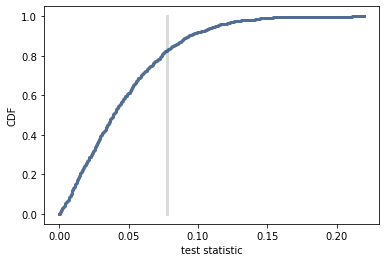

<Figure size 576x432 with 0 Axes>

In [275]:
ht.PlotCdf()
thinkplot.Show(xlabel='test statistic', ylabel='CDF')

In [276]:
1-pvalue

0.827

In [282]:
data2 = firsts.birthwgt_lb, others.birthwgt_lb
ht2 = DiffMeansPermute(data2)
ht2.PValue()

0.0

In [285]:
class DiffMeansOneSided(DiffMeansPermute):
    
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat

p-value: 0.087


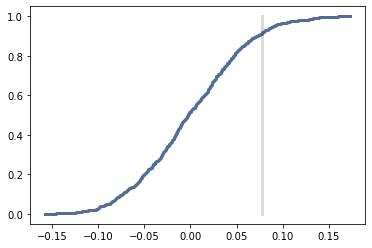

In [291]:
ht_one_sided = DiffMeansOneSided(data)
pval = ht_one_sided.PValue()
ht_one_sided.PlotCdf()
print('p-value:', pval)

In [292]:
class DiffStdPermute(DiffMeansPermute):
    
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat

In [305]:
ht_stdev = DiffStdPermute(data)
ht_stdev.PValue()

0.086

In [312]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [316]:
live_clean = live.dropna(subset=['agepreg', 'totalwgt_lb'])
data = live_clean.agepreg.values, live_clean.totalwgt_lb.values
ht_corr = CorrelationPermute(data)
ht.PValue()

0.0

In [317]:
class DiceTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum(abs(observed - expected))
        return test_stat

    def RunModel(self):
        n = sum(self.data)
        values = [1, 2, 3, 4, 5, 6]
        rolls = np.random.choice(values, n, replace=True)
        hist = thinkstats2.Hist(rolls)
        freqs = hist.Freqs(values)
        return freqs

In [322]:
data = [8, 9, 19, 5, 8, 11]
dt = DiceTest(data)
dt.PValue()

0.124

In [336]:
class DiceChiTest(DiceTest):
    
    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum((observed - expected)**2 / expected)
        return test_stat

In [337]:
dt_chi = DiceChiTest(data)
pvalue = dt_chi.PValue()
pvalue

0.041

In [338]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat 

In [339]:
data = firsts.prglngth.values, others.prglngth.values
ht = PregLengthTest(data)
ht.PValue()

0.0

In [341]:
def FalseNegRate(data, num_runs=1000):

    group1, group2 = data
    count = 0

    for i in range(num_runs):
        sample1 = thinkstats2.Resample(group1)
        sample2 = thinkstats2.Resample(group2)
        
        ht = DiffMeansPermute((sample1, sample2))
        p_value = ht.PValue(iters=101)
        
        if p_value > 0.05:
            count += 1

    return count / num_runs

In [342]:
false_neg = FalseNegRate(data)
false_neg

0.667

In [420]:
def Resample(xs, size):
    return np.random.choice(xs, size, replace=True)

In [ ]:
# Exercise 9-2

In [383]:
# preglngth = firsts.prglngth.values, others.prglngth.values
# brthwght = firsts.birthwgt_lb.values, others.birthwgt_lb.values

# firsts_res = Resample(firsts.prglngth.values)
# others_res = Resample(others.prglngth.values)
# abs(firsts_res.mean() - others_res.mean())

0.048809232394162905

In [461]:
# abs(firsts_res.mean() - others_res.mean())

In [462]:
class DiffMeansResample(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat
    
    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))
        
    def RunModel(self):
        group1_res = Resample(self.pool, self.m)
        group2_res = Resample(self.pool, self.n)
        return group1_res, group2_res

In [466]:
preglngth = firsts.prglngth.values, others.prglngth.values
brthwght = firsts.birthwgt_lb.values, others.birthwgt_lb.values

In [494]:

features_dict = {'preg_length': preglngth, 'birth_weight': brthwght}
for key, val in features_dict.items():
    print()
    ht_resample = DiffMeansResample(val)
    print('DiffMeansResample p-vlaue for {}:'.format(key), ht_resample.PValue(iters=1000))
    ht_permute = DiffMeansPermute(val)
    print('DiffMeansPermute p-value for {}:'.format(key), ht_permute.PValue(iters=1000))
    


DiffMeansResample p-vlaue for preg_length: 0.175
DiffMeansPermute p-value for preg_length: 0.174

DiffMeansResample p-vlaue for birth_weight: 0.0
DiffMeansPermute p-value for birth_weight: 0.0


#### 0utputs from different models:

Resample p-vlaue for preg_length: 0.175<br>
Permutation p-value for preg_length: 0.174<br><br>

Resample p-vlaue for birth_weight: 0.0<br>
Permutation p-value for birth_weight: 0.0<br>

#### Conclusion:
The p-values do not seem to vary much between the two approaches. <br>
The choice of the model does not seem to effect the results in a significant way, <br>
at least in the case of pvalues between different groups in this dataset. <br>

In [ ]:

# the solution Vaughn sent me... 

# class DiffMeansResample(DiffMeansPermute):
#     """Tests a difference in means using resampling."""
#     def RunModel(self):
#         """Run the model of the null hypothesis.
#         returns: simulated data
#         """
#         group1 = np.random.choice(self.pool, self.n, replace=True)
#         group2 = np.random.choice(self.pool, self.m, replace=True)
#         return group1, group2